In [3]:
# make the necessary imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
idx = pd.IndexSlice
import statsmodels.api as sm

from statsmodels.regression.linear_model import OLS
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import coint
from sklearn.model_selection import train_test_split

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Stock Universe and Identification of Cointegrated Pairs of Stocks

In [4]:
# read back the pricing data
prices = pd.read_csv('auto.csv', index_col=['date'])
prices.head(10)

MARUTI.NS  TATAMOTORS.NS      M&M.NS  BAJAJ-AUTO.NS  \
date                                                                
01-01-2018  9651.900391     424.450012  744.650024    3289.250000   
02-01-2018  9554.049805     439.299988  752.900024    3294.750000   
03-01-2018  9416.599609     433.899994  754.900024    3241.050049   
04-01-2018  9386.250000     429.950012  756.000000    3264.449951   
05-01-2018  9433.849609     431.600006  756.349976    3279.850098   
08-01-2018  9448.950195     433.549988  759.900024    3275.750000   
09-01-2018  9383.549805     437.549988  762.450012    3243.500000   
10-01-2018  9375.849609     433.299988  759.849976    3207.399902   
11-01-2018  9339.799805     434.750000  766.650024    3193.399902   
12-01-2018  9459.150391     437.100006  767.500000    3175.350098   

            EICHERMOT.NS  HEROMOTOCO.NS  BALKRISIND.NS  BHARATFORG.NS  \
date                                                                    
01-01-2018   2989.314941    3749.100098    1195.449951     723.000000   
02-01-2018   2867.014893    3743.850098    1173.250000     728.049988   
03-01-2018   2881.435059    3755.199951    1189.050049     733.099976   
04-01-2018   2857.074951    3738.899902    1205.300049     726.950012   
05-01-2018   2923.699951    3744.649902    1210.699951     738.849976   
08-01-2018   2919.739990    3786.750000    1202.800049     742.400024   
09-01-2018   2859.695068    3749.449951    1176.550049     732.599976   
10-01-2018   2809.750000    3736.899902    1166.449951     726.549988   
11-01-2018   2844.469971    3705.649902    1157.849976     727.450012   
12-01-2018   2864.975098    3687.350098    1158.500000     730.599976   

            ASHOKLEY.NS  TIINDIA.NS  
date                                 
01-01-2018   118.650002  269.799988  
02-01-2018   123.349998  268.149994  
03-01-2018   124.500000  273.850006  
04-01-2018   126.949997  280.600006  
05-01-2018   127.449997  294.450012  
08-01-2018   128.449997  294.700012  
09-01-2018   130.500000  295.600006  
10-01-2018   127.949997  294.100006  
11-01-2018   127.050003  287.399994  
12-01-2018   128.649994  287.350006

In [5]:
# train test split 
train_close, test_close = train_test_split(prices, test_size=0.251012, shuffle=False)

In [6]:
# quick view of head and tail of train set
train_close.head(2).append(train_close.tail(2))

MARUTI.NS  TATAMOTORS.NS      M&M.NS  BAJAJ-AUTO.NS  \
date                                                                
01-01-2018  9651.900391     424.450012  744.650024    3289.250000   
02-01-2018  9554.049805     439.299988  752.900024    3294.750000   
30-12-2020  7612.899902     184.149994  720.700012    3448.149902   
31-12-2020  7649.600098     183.850006  720.599976    3444.050049   

            EICHERMOT.NS  HEROMOTOCO.NS  BALKRISIND.NS  BHARATFORG.NS  \
date                                                                    
01-01-2018   2989.314941    3749.100098    1195.449951     723.000000   
02-01-2018   2867.014893    3743.850098    1173.250000     728.049988   
30-12-2020   2517.350098    3101.399902    1615.050049     517.599976   
31-12-2020   2530.899902    3110.000000    1646.300049     525.299988   

            ASHOKLEY.NS  TIINDIA.NS  
date                                 
01-01-2018   118.650002  269.799988  
02-01-2018   123.349998  268.149994  
30-12-2020    94.800003  793.299988  
31-12-2020    95.449997  800.849976

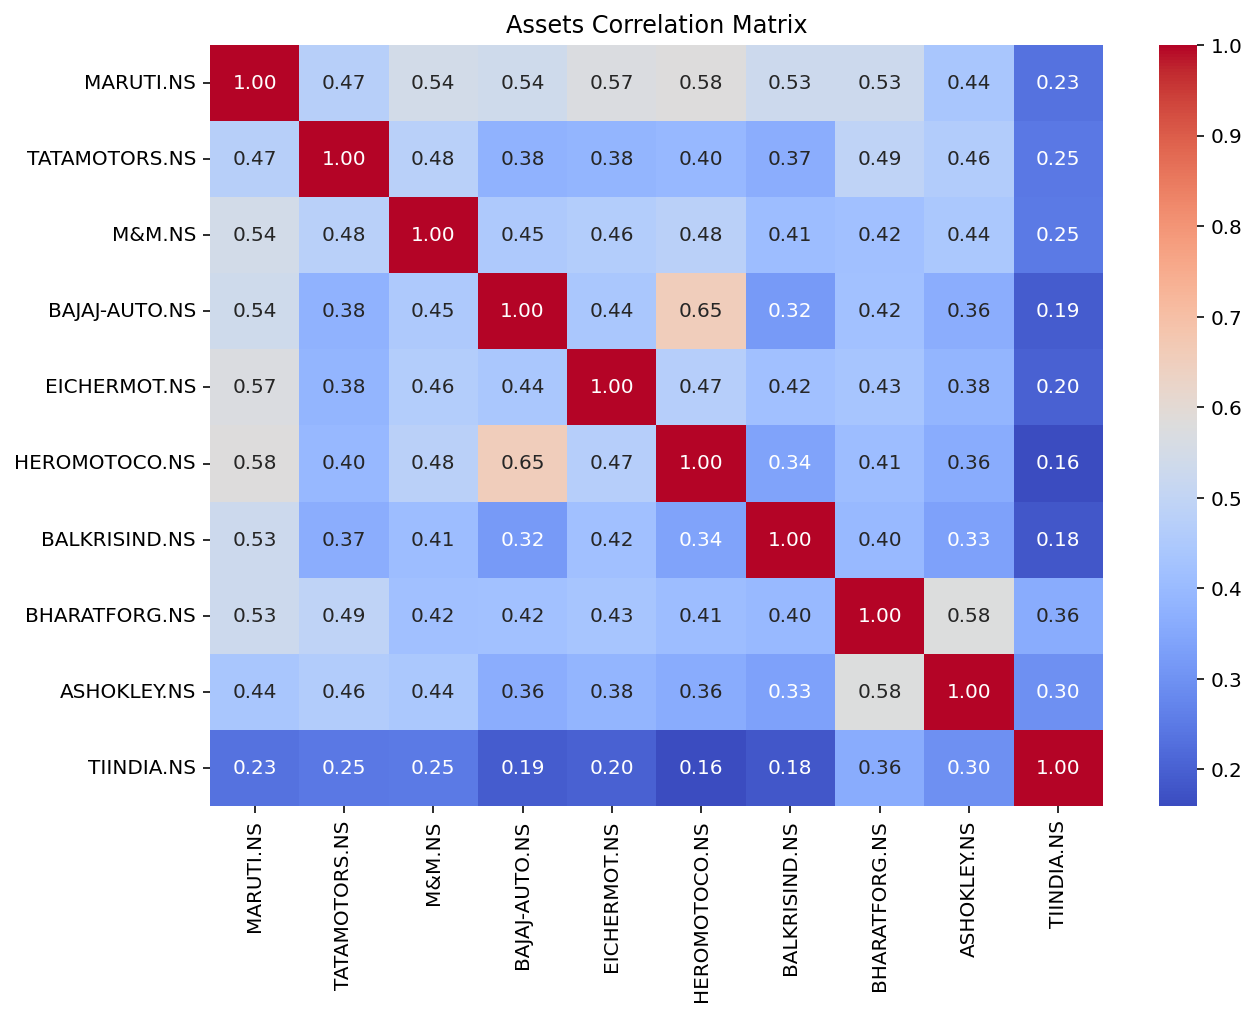

In [7]:
# Pearson correlation to get the basic idea about the relationship
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(train_close.pct_change().corr(method ='pearson'), ax=ax, cmap='coolwarm', annot=True, fmt=".2f") #spearman
ax.set_title('Assets Correlation Matrix')
plt.savefig('chart1', dpi=400)

In [8]:
# function to find cointegrated pairs
def find_cointegrated_pairs(data):
    n = data.shape[1]
    pvalue_matrix = np.ones((n, n))
    keys = data.keys()
    pairs = []
    for i in range(n):
        for j in range(i+1, n):
            result = coint(data[keys[i]], data[keys[j]])
            pvalue_matrix[i, j] = result[1]
            if result[1] < 0.05:
                pairs.append((keys[i], keys[j]))
    return pvalue_matrix, pairs

[('MARUTI.NS', 'EICHERMOT.NS'), ('MARUTI.NS', 'BHARATFORG.NS'), ('MARUTI.NS', 'ASHOKLEY.NS'), ('TATAMOTORS.NS', 'M&M.NS'), ('TATAMOTORS.NS', 'BHARATFORG.NS'), ('TATAMOTORS.NS', 'ASHOKLEY.NS'), ('EICHERMOT.NS', 'HEROMOTOCO.NS'), ('EICHERMOT.NS', 'BHARATFORG.NS'), ('EICHERMOT.NS', 'ASHOKLEY.NS'), ('BHARATFORG.NS', 'ASHOKLEY.NS')]


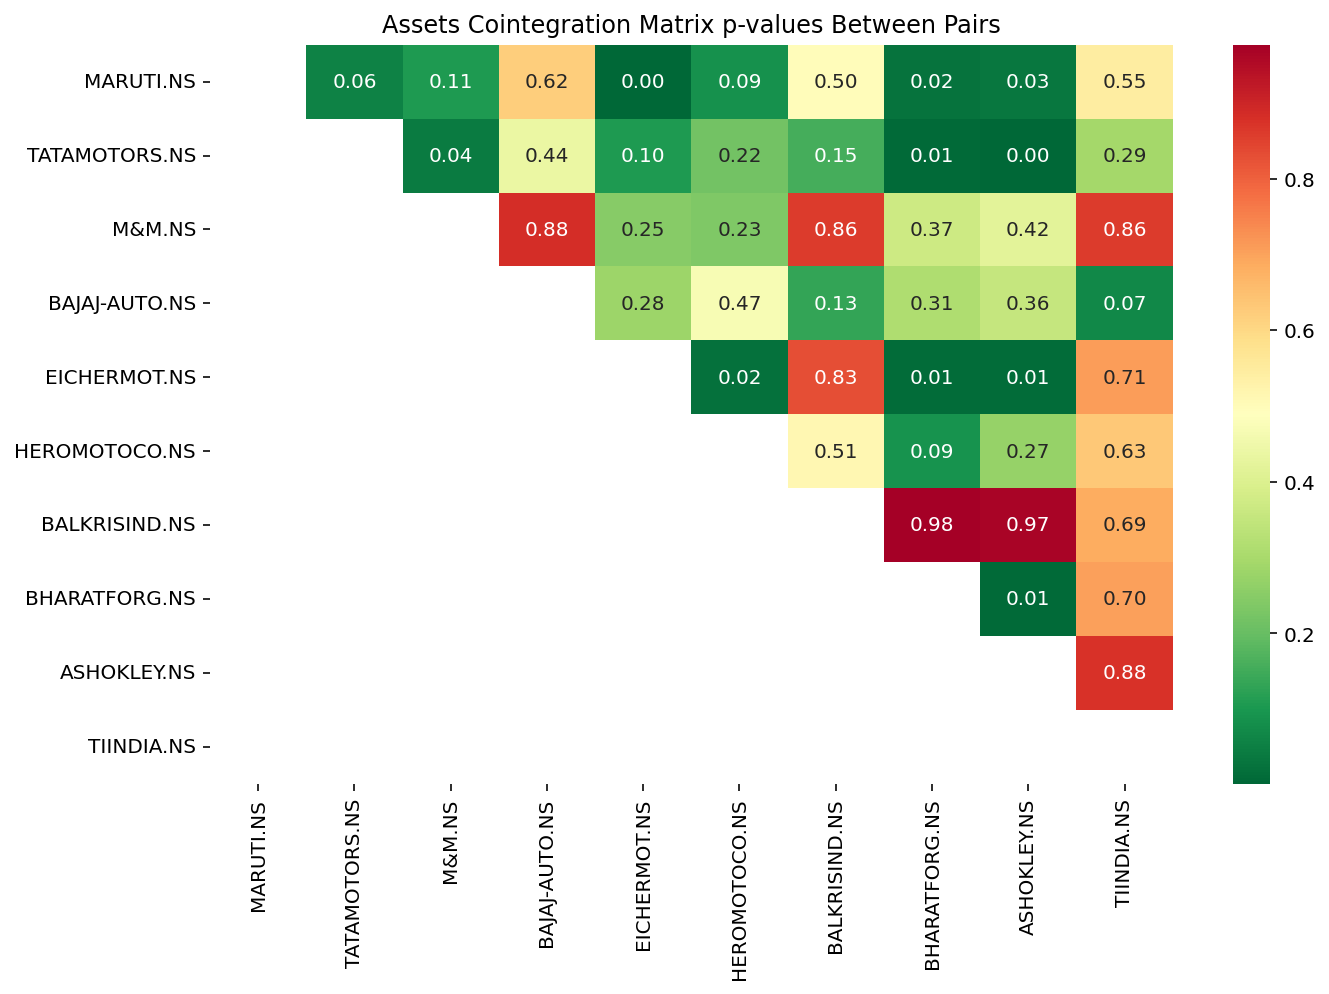

In [9]:
# calculate p-values and plot as a heatmap
pvalues, pairs = find_cointegrated_pairs(train_close)
print(pairs)
fig, ax = plt.subplots(figsize=(10,7))
sns.heatmap(pvalues, xticklabels = train_close.columns,
                yticklabels = train_close.columns, cmap = 'RdYlGn_r', annot = True, fmt=".2f",
                mask = (pvalues >= 0.99))
ax.set_title('Assets Cointegration Matrix p-values Between Pairs')
plt.tight_layout()
plt.savefig('chart2', dpi=400) 

### Perform a Cointegration test for the Selected Pair

In [10]:
# final pair to test strategy
asset1 = 'EICHERMOT.NS'
asset2 = 'HEROMOTOCO.NS'

In [11]:
# create a train dataframe of 2 assets
train = pd.DataFrame()
train['asset1'] = train_close[asset1]
train['asset2'] = train_close[asset2]

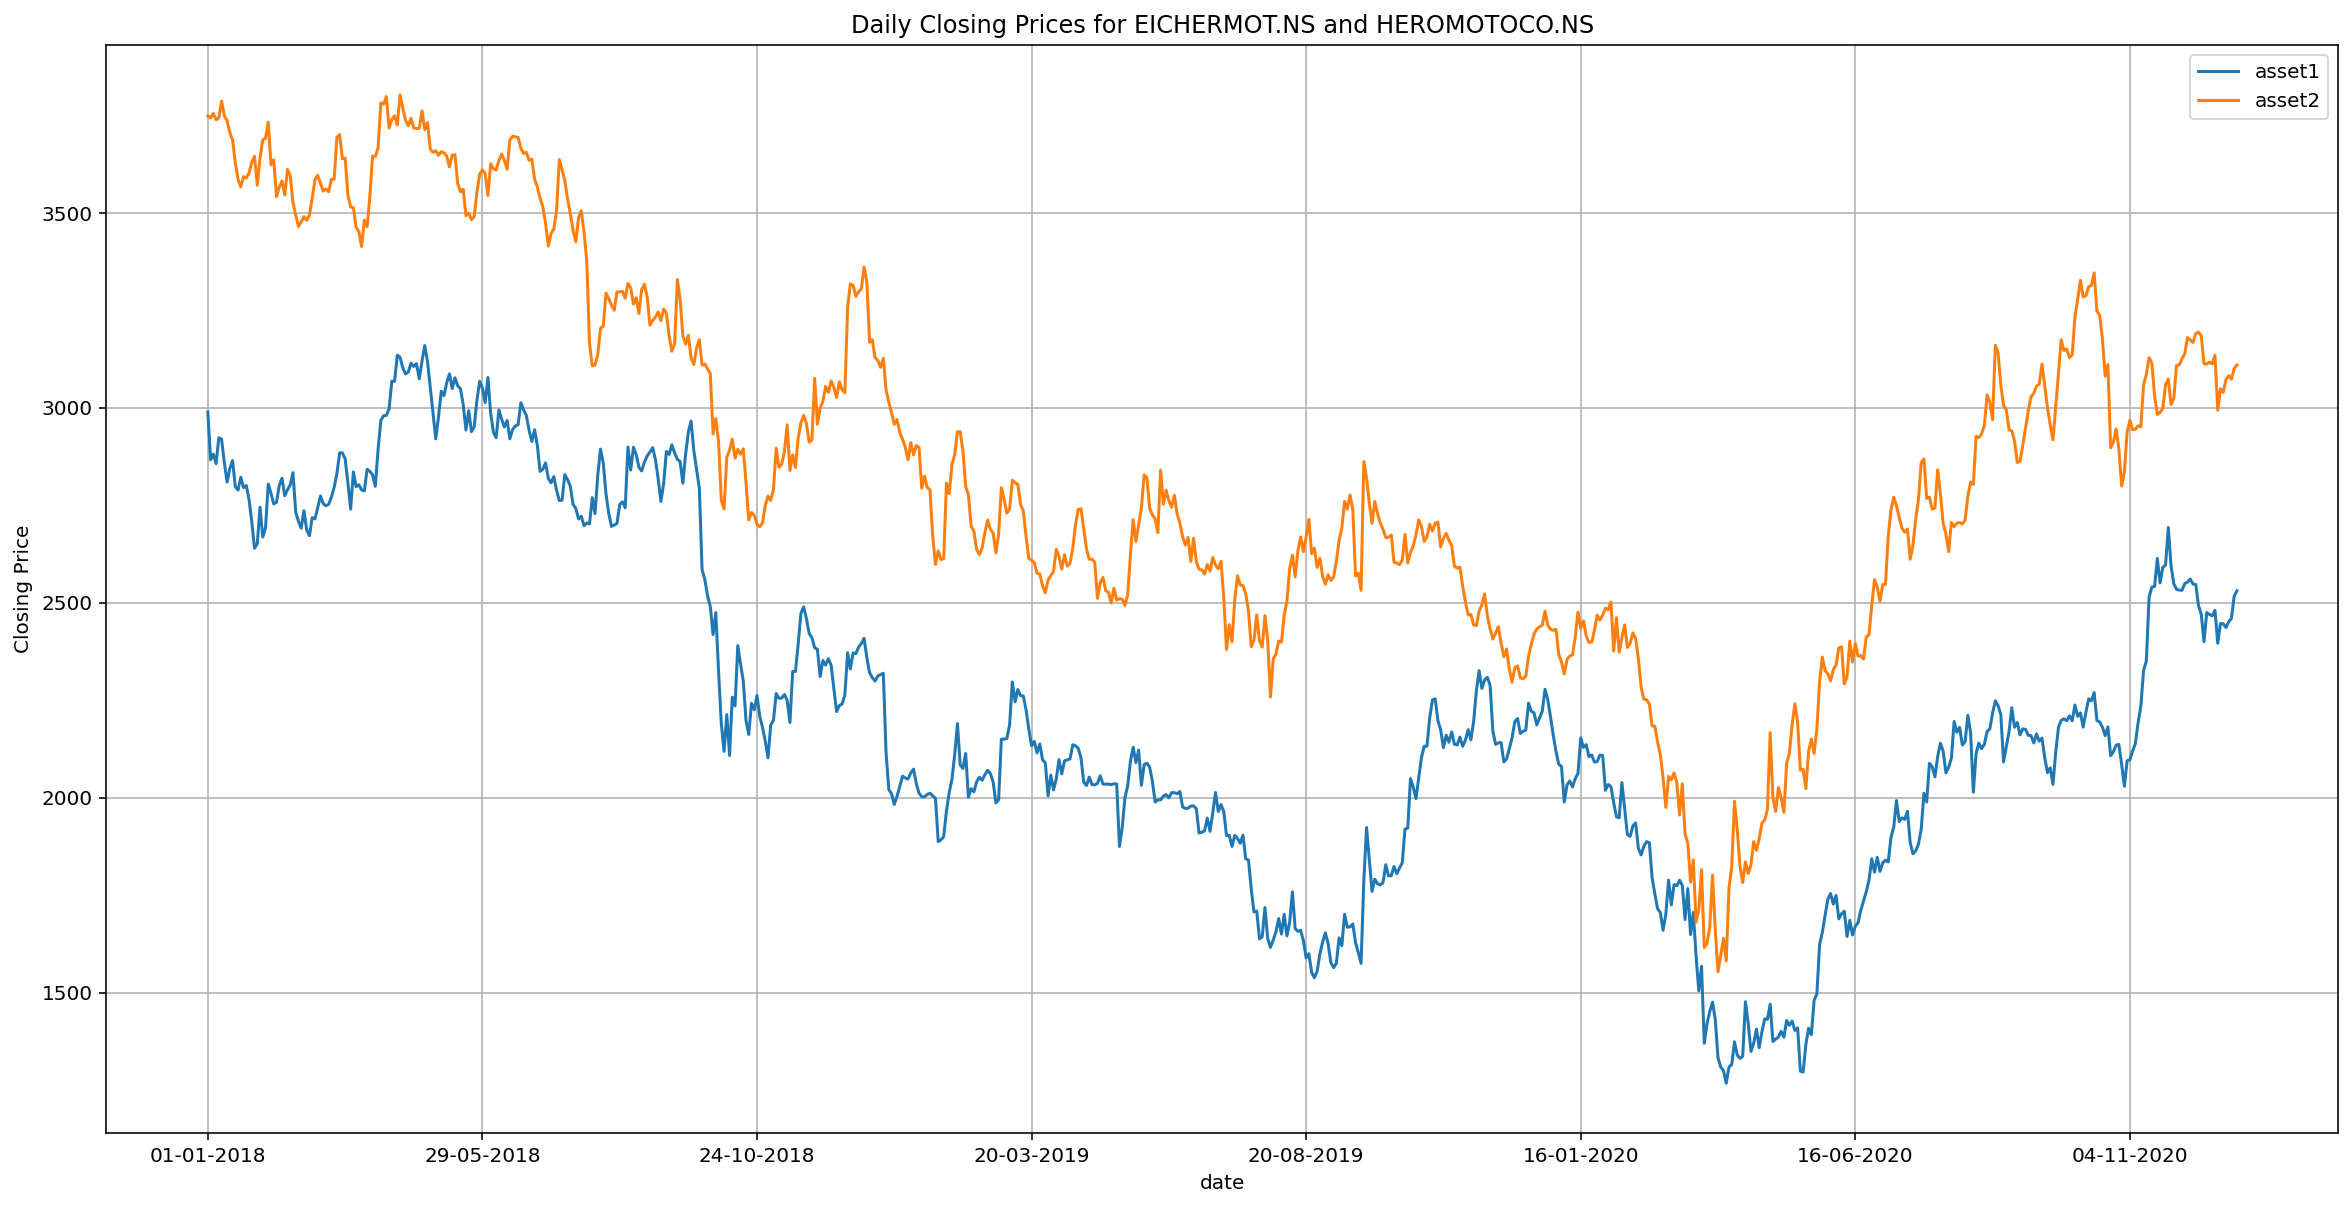

In [12]:
from matplotlib.dates import DateFormatter
# visualize closing prices
ax = train[['asset1','asset2']].plot(figsize=(20, 10), title = 'Daily Closing Prices for {} and {}'.format(asset1,asset2))
ax.set_ylabel("Closing Price")
#date_form = DateFormatter("%Y")
# ax.xaxis.set_major_formatter(date_form)
ax.grid(True);
plt.savefig('chart3', dpi=400) 

In [13]:
# run OLS regression
model=sm.OLS(train.asset2, train.asset1).fit()

In [14]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 asset2   R-squared (uncentered):                   0.993
Model:                            OLS   Adj. R-squared (uncentered):              0.993
Method:                 Least Squares   F-statistic:                          9.937e+04
Date:                Mon, 21 Mar 2022   Prob (F-statistic):                        0.00
Time:                        17:34:09   Log-Likelihood:                         -5134.3
No. Observations:                 740   AIC:                                  1.027e+04
Df Residuals:                     739   BIC:                                  1.028e+04
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
asset1         1.2747      0.004    315.225      0.000       1.267       1.283
==============================================================================
Omnibus:                        4.508   Durbin-Watson:                   0.066
Prob(Omnibus):                  0.105   Jarque-Bera (JB):                3.582
Skew:                           0.055   Prob(JB):                        0.167
Kurtosis:                       2.677   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

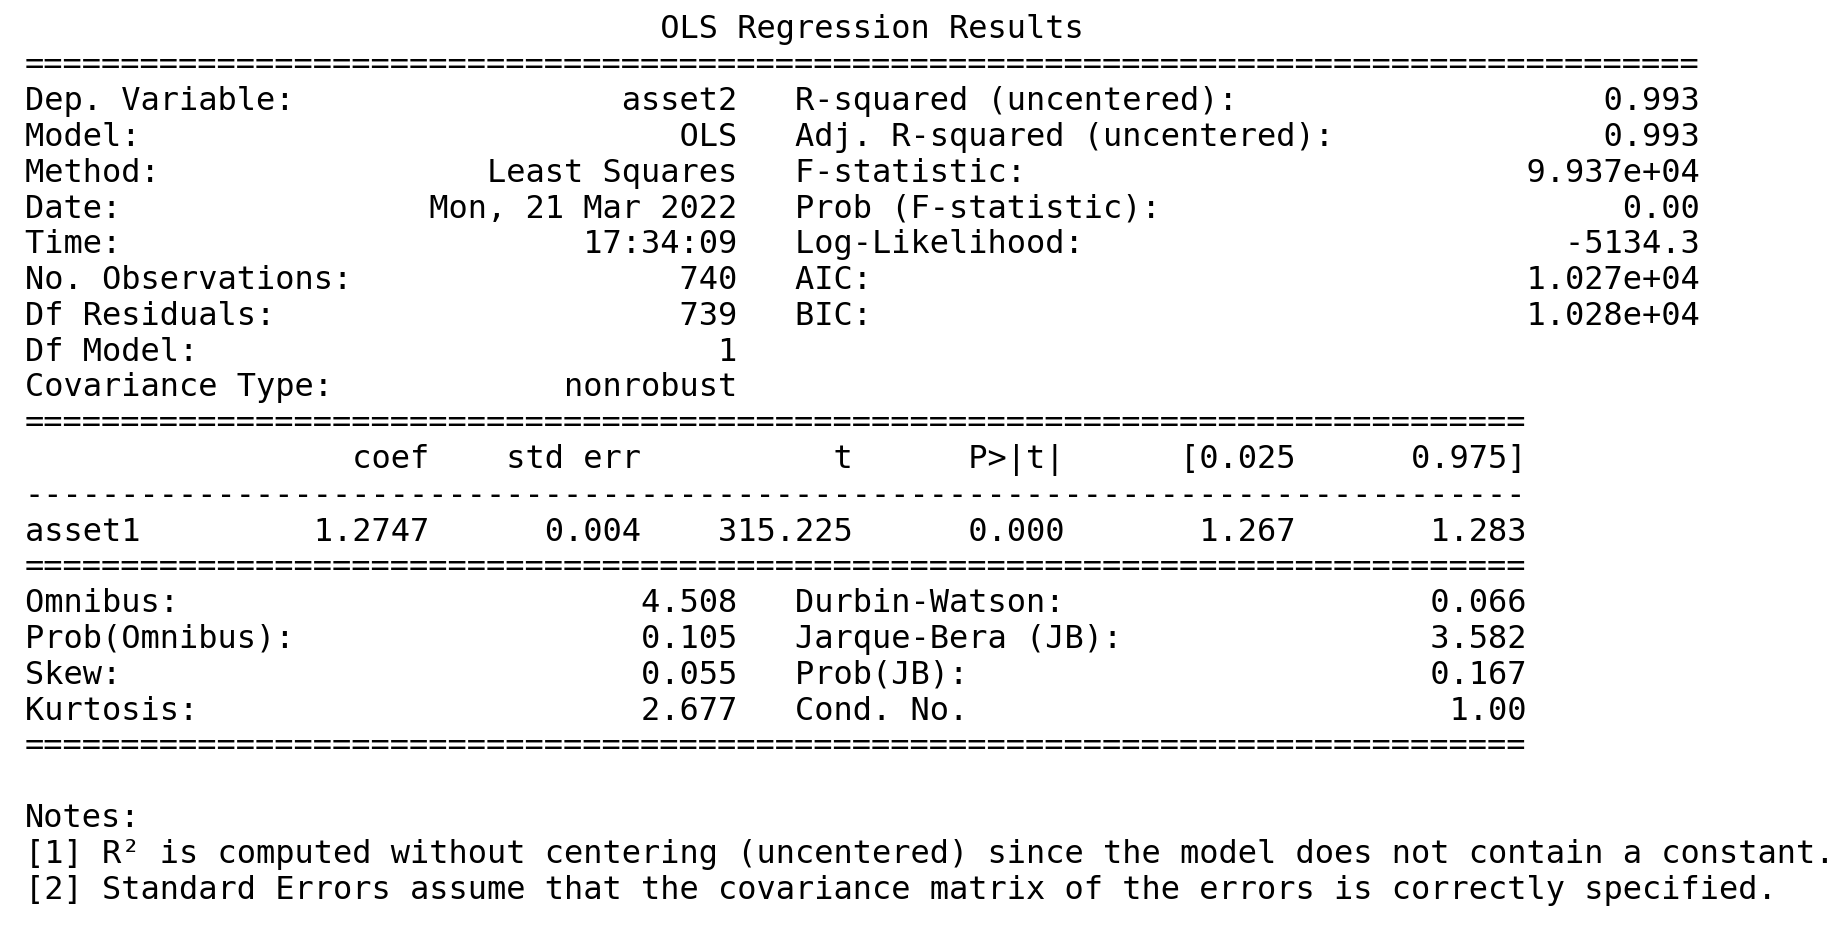

In [15]:
# print regression summary results
plt.rc('figure', figsize=(12, 7))
plt.text(0.01, 0.05, str(model.summary()), {'fontsize': 16}, fontproperties = 'monospace')
plt.axis('off')
plt.tight_layout()
plt.subplots_adjust(left=0.2, right=0.8, top=0.7, bottom=0.1)
plt.savefig('chart4', dpi=400);

In [16]:
model.params[0]

1.2746737583862073

In [17]:
print('Hedge Ratio = ', model.params[0])

Hedge Ratio =  1.2746737583862073


In [18]:
# calculate spread
spread = train.asset2 - model.params[0] * train.asset1

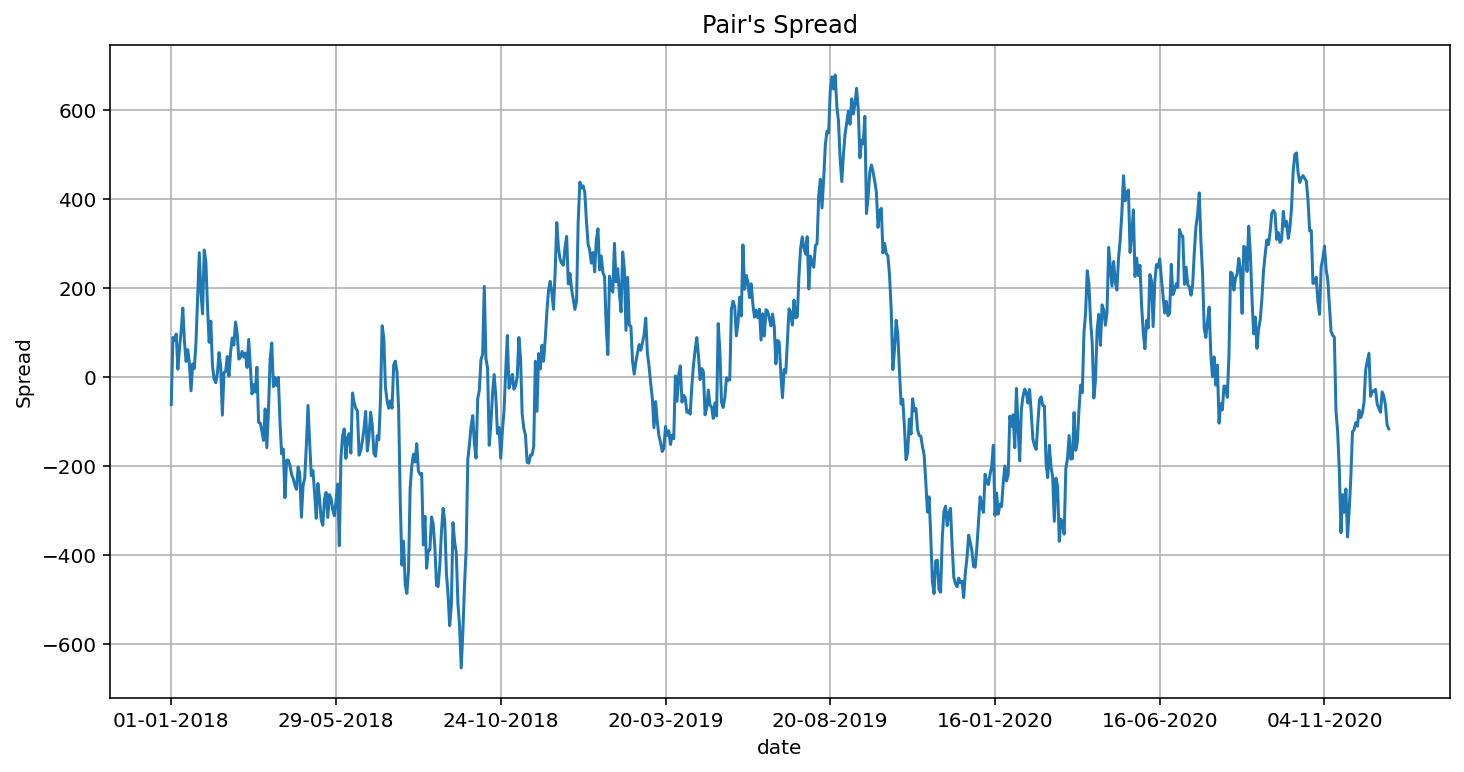

In [19]:
# Plot the spread
ax = spread.plot(figsize=(12, 6), title = "Pair's Spread")
ax.set_ylabel("Spread")
ax.grid(True);
plt.savefig('chart5', dpi=400);

In [20]:
# conduct Augmented Dickey-Fuller test
adf = adfuller(spread, maxlag = 1)
adf

(-3.529243060356555,
 0.007267074667390699,
 0,
 739,
 {'1%': -3.439229783394421,
  '5%': -2.86545894814762,
  '10%': -2.5688568756191392},
 8226.189832929234)

In [21]:
print('Critical Value = ', adf[0])

Critical Value =  -3.529243060356555


In [22]:
# probablity critical values
print(adf[4])

{'1%': -3.439229783394421, '5%': -2.86545894814762, '10%': -2.5688568756191392}


### Generate Trading Signals using z-score

In [23]:
# calculate z-score
def zscore(series):
    return (series - series.mean()) / np.std(series)

In [24]:
# create a dataframe for trading signals
signals = pd.DataFrame()
signals['asset1'] = test_close[asset1] 
signals['asset2'] = test_close[asset2]
ratios = signals.asset1 / signals.asset2

In [25]:
signals.head()

asset1       asset2
date                                
01-01-2021  2542.699951  3102.649902
04-01-2021  2655.699951  3043.850098
05-01-2021  2674.899902  3067.199951
06-01-2021  2645.350098  3083.550049
07-01-2021  2649.800049  3055.250000

In [26]:
# calculate z-score and define upper and lower thresholds
signals['z'] = zscore(ratios)
signals['z upper limit'] = np.mean(signals['z']) + np.std(signals['z'])
signals['z lower limit'] = np.mean(signals['z']) - np.std(signals['z'])

In [27]:
signals.head()

asset1       asset2         z  z upper limit  z lower limit
date                                                                        
01-01-2021  2542.699951  3102.649902 -1.287330            1.0           -1.0
04-01-2021  2655.699951  3043.850098 -0.570113            1.0           -1.0
05-01-2021  2674.899902  3067.199951 -0.575290            1.0           -1.0
06-01-2021  2645.350098  3083.550049 -0.767710            1.0           -1.0
07-01-2021  2649.800049  3055.250000 -0.640358            1.0           -1.0

In [28]:
# create signal - short if z-score is greater than upper limit else long
signals['signals1'] = 0
signals['signals1'] = np.select([signals['z'] > \
                                 signals['z upper limit'], signals['z'] < signals['z lower limit']], [-1, 1], default=0)

In [29]:
# we take the first order difference to obtain portfolio position in that stock
signals['positions1'] = signals['signals1'].diff()
signals['signals2'] = -signals['signals1']
signals['positions2'] = signals['signals2'].diff()

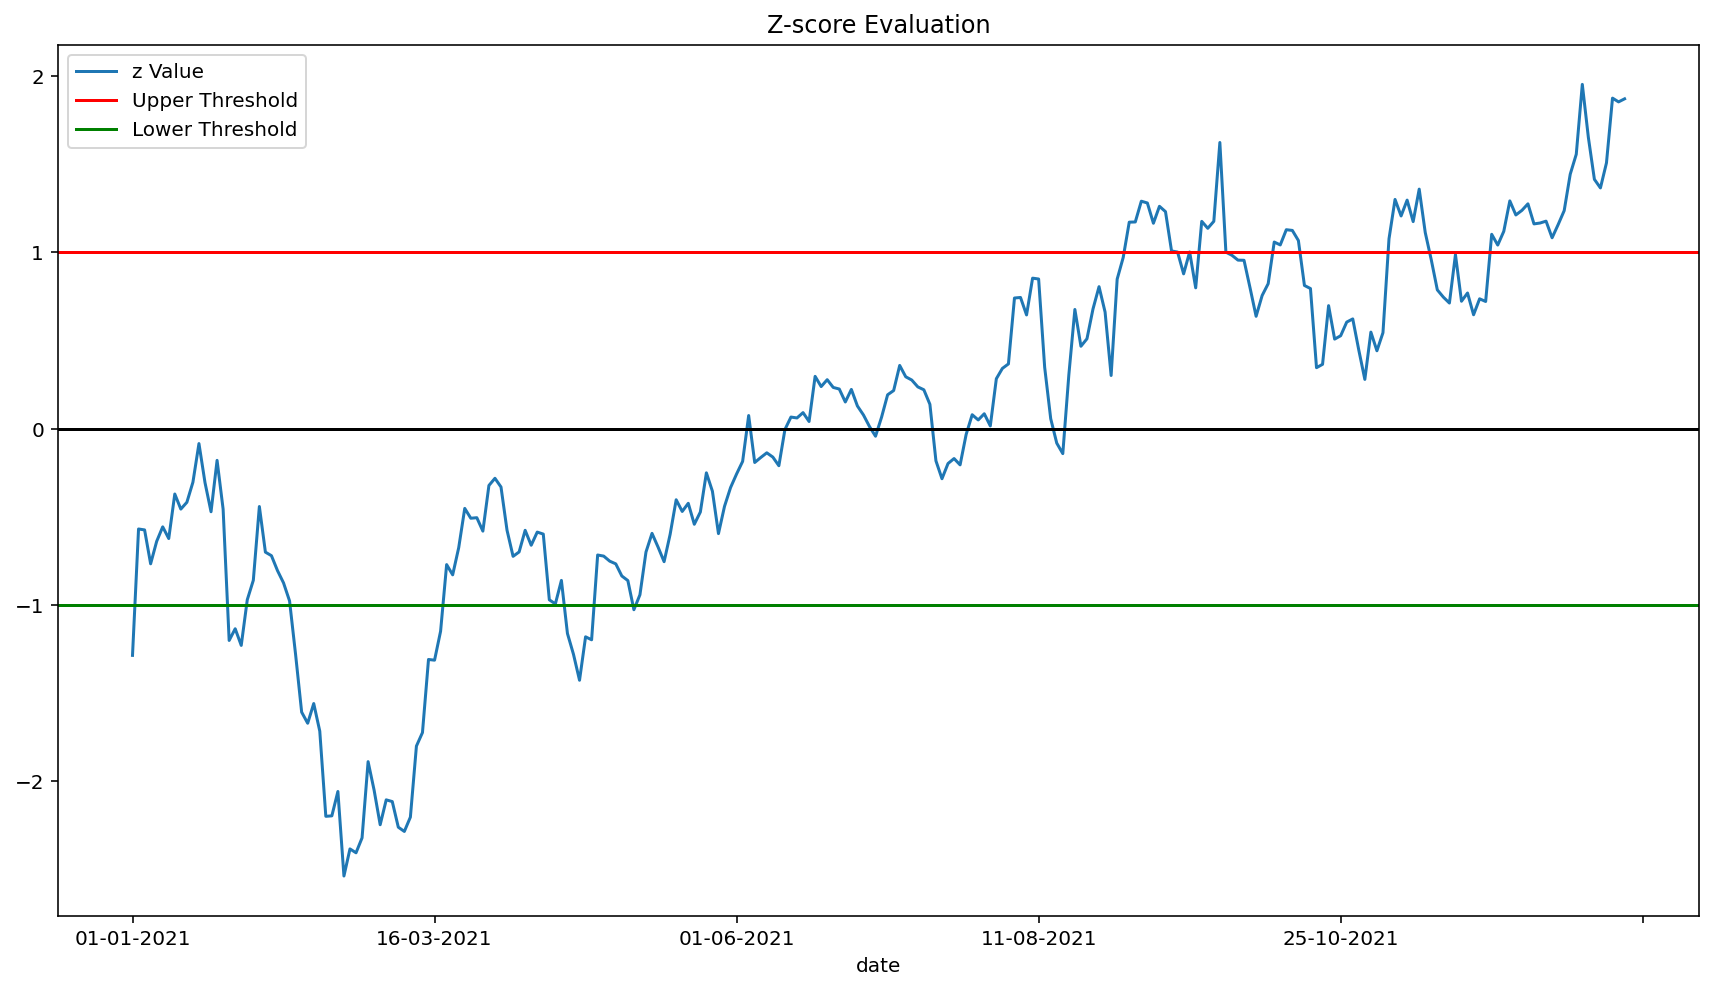

In [30]:
# # visualize z-score and upper and lower thresholds   
signals['z'].plot(label="z Value")
plt.title("Z-score Evaluation")
plt.axhline(signals['z'].mean(),color="black")
plt.axhline(signals['z upper limit'].mean(), color="red", label="Upper Threshold")
plt.axhline(signals['z lower limit'].mean(), color="green", label="Lower Threshold")
plt.legend()
plt.tight_layout()
plt.savefig('chart6', dpi=400);

In [31]:
# verify dataframe head and tail
signals.head(3).append(signals.tail(3))

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2542.699951  3102.649902 -1.287330            1.0           -1.0   
04-01-2021  2655.699951  3043.850098 -0.570113            1.0           -1.0   
05-01-2021  2674.899902  3067.199951 -0.575290            1.0           -1.0   
29-12-2021  2562.250000  2433.250000  1.875022            1.0           -1.0   
30-12-2021  2557.000000  2431.899902  1.853701            1.0           -1.0   
31-12-2021  2591.899902  2462.100098  1.871008            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         0        -1.0         0         1.0  
05-01-2021         0         0.0         0         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0

In [32]:
# # check portfolio position
signals[signals.signals1 != 0].head(10)

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2542.699951  3102.649902 -1.287330            1.0           -1.0   
25-01-2021  2869.550049  3474.949951 -1.202594            1.0           -1.0   
27-01-2021  2789.899902  3358.550049 -1.136173            1.0           -1.0   
28-01-2021  2798.449951  3397.399902 -1.230742            1.0           -1.0   
10-02-2021  2901.300049  3538.949951 -1.283345            1.0           -1.0   
11-02-2021  2818.149902  3541.500000 -1.609333            1.0           -1.0   
12-02-2021  2781.250000  3515.750000 -1.672547            1.0           -1.0   
15-02-2021  2770.050049  3465.399902 -1.560648            1.0           -1.0   
16-02-2021  2726.949951  3461.550049 -1.717243            1.0           -1.0   
17-02-2021  2695.500000  3584.000000 -2.200626            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
25-01-2021         1         1.0        -1        -1.0  
27-01-2021         1         0.0        -1         0.0  
28-01-2021         1         0.0        -1         0.0  
10-02-2021         1         1.0        -1        -1.0  
11-02-2021         1         0.0        -1         0.0  
12-02-2021         1         0.0        -1         0.0  
15-02-2021         1         0.0        -1         0.0  
16-02-2021         1         0.0        -1         0.0  
17-02-2021         1         0.0        -1         0.0

In [33]:
signals[signals.positions1 != 0].head().append(signals[signals.positions1 != 0].tail())

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2542.699951  3102.649902 -1.287330            1.0           -1.0   
04-01-2021  2655.699951  3043.850098 -0.570113            1.0           -1.0   
25-01-2021  2869.550049  3474.949951 -1.202594            1.0           -1.0   
29-01-2021  2744.300049  3256.050049 -0.971680            1.0           -1.0   
10-02-2021  2901.300049  3538.949951 -1.283345            1.0           -1.0   
07-10-2021  2820.949951  2841.649902  1.058329            1.0           -1.0   
14-10-2021  2853.199951  2927.800049  0.811893            1.0           -1.0   
04-11-2021  2661.600098  2677.500000  1.076561            1.0           -1.0   
16-11-2021  2710.300049  2750.899902  0.957099            1.0           -1.0   
01-12-2021  2438.300049  2448.199951  1.102221            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         0        -1.0         0         1.0  
25-01-2021         1         1.0        -1        -1.0  
29-01-2021         0        -1.0         0         1.0  
10-02-2021         1         1.0        -1        -1.0  
07-10-2021        -1        -1.0         1         1.0  
14-10-2021         0         1.0         0        -1.0  
04-11-2021        -1        -1.0         1         1.0  
16-11-2021         0         1.0         0        -1.0  
01-12-2021        -1        -1.0         1         1.0

In [34]:
signals.loc[signals['positions1'] == 1].index
signals['asset1'][signals['positions1'] == 1].value_counts()

2869.550049    1
2901.300049    1
2340.000000    1
2443.250000    1
2860.199951    1
2813.000000    1
2883.050049    1
2853.199951    1
2710.300049    1
Name: asset1, dtype: int64

In [35]:
signals

asset1       asset2         z  z upper limit  z lower limit  \
date                                                                           
01-01-2021  2542.699951  3102.649902 -1.287330            1.0           -1.0   
04-01-2021  2655.699951  3043.850098 -0.570113            1.0           -1.0   
05-01-2021  2674.899902  3067.199951 -0.575290            1.0           -1.0   
06-01-2021  2645.350098  3083.550049 -0.767710            1.0           -1.0   
07-01-2021  2649.800049  3055.250000 -0.640358            1.0           -1.0   
...                 ...          ...       ...            ...            ...   
27-12-2021  2438.949951  2402.000000  1.365333            1.0           -1.0   
28-12-2021  2480.399902  2417.800049  1.507655            1.0           -1.0   
29-12-2021  2562.250000  2433.250000  1.875022            1.0           -1.0   
30-12-2021  2557.000000  2431.899902  1.853701            1.0           -1.0   
31-12-2021  2591.899902  2462.100098  1.871008            1.0           -1.0   

            signals1  positions1  signals2  positions2  
date                                                    
01-01-2021         1         NaN        -1         NaN  
04-01-2021         0        -1.0         0         1.0  
05-01-2021         0         0.0         0         0.0  
06-01-2021         0         0.0         0         0.0  
07-01-2021         0         0.0         0         0.0  
...              ...         ...       ...         ...  
27-12-2021        -1         0.0         1         0.0  
28-12-2021        -1         0.0         1         0.0  
29-12-2021        -1         0.0         1         0.0  
30-12-2021        -1         0.0         1         0.0  
31-12-2021        -1         0.0         1         0.0  

[248 rows x 9 columns]

In [36]:
signals = signals.reset_index()

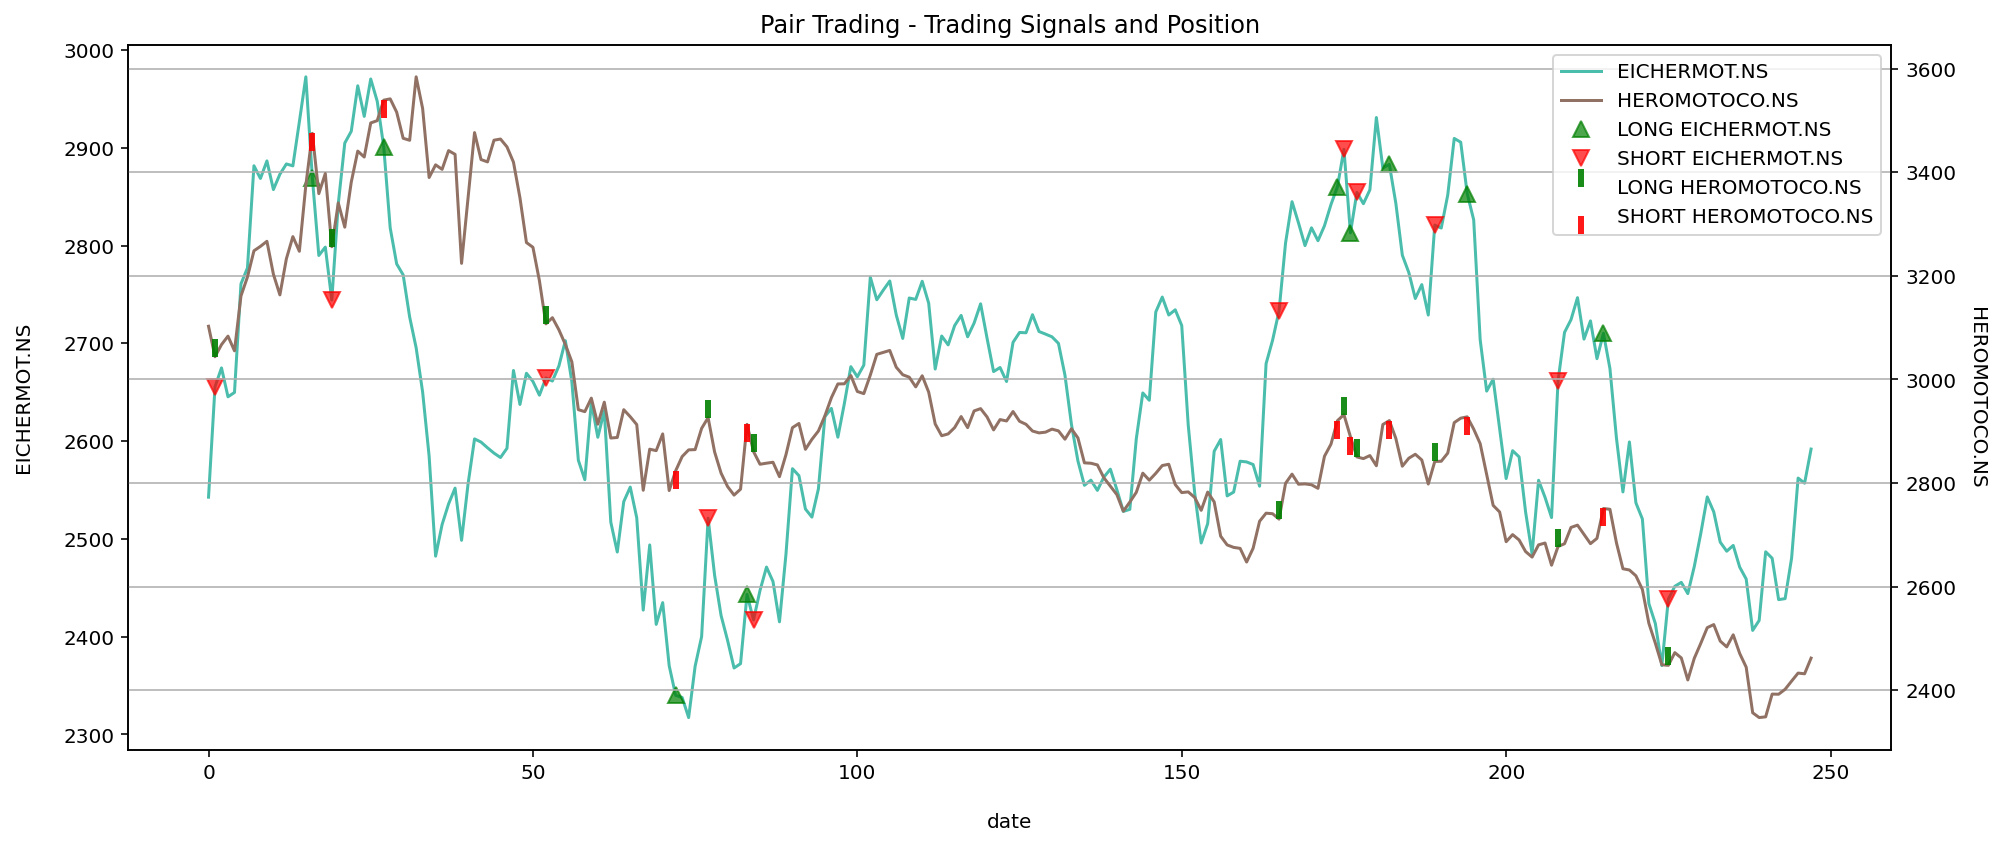

In [37]:
# visualize trading signals and position
fig=plt.figure(figsize=(14,6))
bx = fig.add_subplot(111)   
bx2 = bx.twinx()

#plot two different assets
l1, = bx.plot(signals['asset1'], c='#4abdac')
l2, = bx2.plot(signals['asset2'], c='#907163')

u1, = bx.plot(signals['asset1'][signals['positions1'] == 1], lw=0, marker='^', markersize=8, c='g',alpha=0.7)

d1, = bx.plot(signals['asset1'][signals['positions1'] == -1], lw=0,marker='v',markersize=8, c='r',alpha=0.7)

u2, = bx2.plot(signals['asset2'][signals['positions2'] == 1], lw=0,marker=2,markersize=9, c='g',alpha=0.9, markeredgewidth=3)

d2, = bx2.plot(signals['asset2'][signals['positions2'] == -1], lw=0,marker=3,markersize=9, c='r',alpha=0.9,markeredgewidth=3)

bx.set_ylabel(asset1,)
bx2.set_ylabel(asset2, rotation=270)
bx.yaxis.labelpad=15
bx2.yaxis.labelpad=15
bx.set_xlabel('date')
# bx.xaxis.set_major_formatter(DateFormatter("%Y"))
# bx2.xaxis.set_major_formatter(DateFormatter("%Y"))
bx.xaxis.labelpad=15

plt.legend([l1,l2,u1,d1,u2,d2], [asset1, asset2,'LONG {}'.format(asset1),
           'SHORT {}'.format(asset1),
           'LONG {}'.format(asset2),
           'SHORT {}'.format(asset2)], loc ='best')

plt.title('Pair Trading - Trading Signals and Position')
plt.xlabel('Date')
plt.grid(True)
plt.tight_layout()
plt.savefig('chart7', dpi=400);

### Portfolio Profit and Loss Calculation

In [38]:
# initial capital to calculate the actual pnl
initial_capital = 100000

# shares to buy for each position
positions1 = initial_capital// max(signals['asset1'])
positions2 = initial_capital// max(signals['asset2'])

In [39]:
# since there are two assets, we calculate each asset Pnl separately 
# and in the end we aggregate them into one portfolio
portfolio = pd.DataFrame()
portfolio['asset1'] = signals['asset1']
portfolio['holdings1'] = signals['positions1'].cumsum() * signals['asset1'] * positions1
portfolio['cash1'] = initial_capital - (signals['positions1'] * signals['asset1'] * positions1).cumsum()
portfolio['total asset1'] = portfolio['holdings1'] + portfolio['cash1']
portfolio['return1'] = portfolio['total asset1'].pct_change()
portfolio['positions1'] = signals['positions1']

In [40]:
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    2542.699951            NaN            NaN            NaN       NaN   
1    2655.699951  -87638.098383  187638.098383  100000.000000       NaN   
2    2674.899902  -88271.696766  187638.098383   99366.401617 -0.006336   
3    2645.350098  -87296.553234  187638.098383  100341.545149  0.009814   
4    2649.800049  -87443.401617  187638.098383  100194.696766 -0.001463   
243  2438.949951 -160970.696766  256291.295149   95320.598383 -0.000727   
244  2480.399902 -163706.393532  256291.295149   92584.901617 -0.028700   
245  2562.250000 -169108.500000  256291.295149   87182.795149 -0.058348   
246  2557.000000 -168762.000000  256291.295149   87529.295149  0.003974   
247  2591.899902 -171065.393532  256291.295149   85225.901617 -0.026316   

     positions1  
0           NaN  
1          -1.0  
2           0.0  
3           0.0  
4           0.0  
243         0.0  
244         0.0  
245         0.0  
246         0.0  
247         0.0

In [41]:
portfolio[portfolio.positions1 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   2542.699951           NaN            NaN            NaN       NaN   
1   2655.699951 -87638.098383  187638.098383  100000.000000       NaN   
16  2869.550049      0.000000   92942.946766   92942.946766  0.037978   
19  2744.300049 -90561.901617  183504.848383   92942.946766  0.000000   
27  2901.300049      0.000000   87761.946766   87761.946766  0.017737   

    positions1  
0          NaN  
1         -1.0  
16         1.0  
19        -1.0  
27         1.0

In [42]:
# pnl for the 2nd asset
portfolio['asset2'] = signals['asset2']
portfolio['holdings2'] = signals['positions2'].cumsum() * signals['asset2'] * positions2
portfolio['cash2'] = initial_capital - (signals['positions2'] * signals['asset2'] * positions2).cumsum()
portfolio['total asset2'] = portfolio['holdings2'] + portfolio['cash2']
portfolio['return2'] = portfolio['total asset2'].pct_change()
portfolio['positions2'] = signals['positions2']

In [43]:
portfolio.to_csv('portfolio.csv')
portfolio.head().append(portfolio.tail())

asset1      holdings1          cash1   total asset1   return1  \
0    2542.699951            NaN            NaN            NaN       NaN   
1    2655.699951  -87638.098383  187638.098383  100000.000000       NaN   
2    2674.899902  -88271.696766  187638.098383   99366.401617 -0.006336   
3    2645.350098  -87296.553234  187638.098383  100341.545149  0.009814   
4    2649.800049  -87443.401617  187638.098383  100194.696766 -0.001463   
243  2438.949951 -160970.696766  256291.295149   95320.598383 -0.000727   
244  2480.399902 -163706.393532  256291.295149   92584.901617 -0.028700   
245  2562.250000 -169108.500000  256291.295149   87182.795149 -0.058348   
246  2557.000000 -168762.000000  256291.295149   87529.295149  0.003974   
247  2591.899902 -171065.393532  256291.295149   85225.901617 -0.026316   

     positions1       asset2      holdings2         cash2   total asset2  \
0           NaN  3102.649902            NaN           NaN            NaN   
1          -1.0  3043.850098   82183.952646  17816.047354  100000.000000   
2           0.0  3067.199951   82814.398677  17816.047354  100630.446031   
3           0.0  3083.550049   83255.851323  17816.047354  101071.898677   
4           0.0  3055.250000   82491.750000  17816.047354  100307.797354   
243         0.0  2402.000000  129708.000000 -21887.459261  107820.540739   
244         0.0  2417.800049  130561.202646 -21887.459261  108673.743385   
245         0.0  2433.250000  131395.500000 -21887.459261  109508.040739   
246         0.0  2431.899902  131322.594708 -21887.459261  109435.135447   
247         0.0  2462.100098  132953.405292 -21887.459261  111065.946031   

      return2  positions2  
0         NaN         NaN  
1         NaN         1.0  
2    0.006304         0.0  
3    0.004387         0.0  
4   -0.007560         0.0  
243  0.004806         0.0  
244  0.007913         0.0  
245  0.007677         0.0  
246 -0.000666         0.0  
247  0.014902         0.0

In [44]:
portfolio[portfolio.positions2 != 0].head()

asset1     holdings1          cash1   total asset1   return1  \
0   2542.699951           NaN            NaN            NaN       NaN   
1   2655.699951 -87638.098383  187638.098383  100000.000000       NaN   
16  2869.550049      0.000000   92942.946766   92942.946766  0.037978   
19  2744.300049 -90561.901617  183504.848383   92942.946766  0.000000   
27  2901.300049      0.000000   87761.946766   87761.946766  0.017737   

    positions1       asset2     holdings2          cash2   total asset2  \
0          NaN  3102.649902           NaN            NaN            NaN   
1         -1.0  3043.850098  82183.952646   17816.047354  100000.000000   
16         1.0  3474.949951      0.000000  111639.696031  111639.696031   
19        -1.0  3256.050049  87913.351323   23726.344708  111639.696031   
27         1.0  3538.949951      0.000000  119277.993385  119277.993385   

     return2  positions2  
0        NaN         NaN  
1        NaN         1.0  
16  0.024797        -1.0  
19  0.000000         1.0  
27  0.009022        -1.0

In [45]:
# total pnl and z-score
portfolio['z'] = signals['z']
portfolio['total asset'] = portfolio['total asset1'] + portfolio['total asset2']
portfolio['z upper limit'] = signals['z upper limit']
portfolio['z lower limit'] = signals['z lower limit']
portfolio = portfolio.dropna()

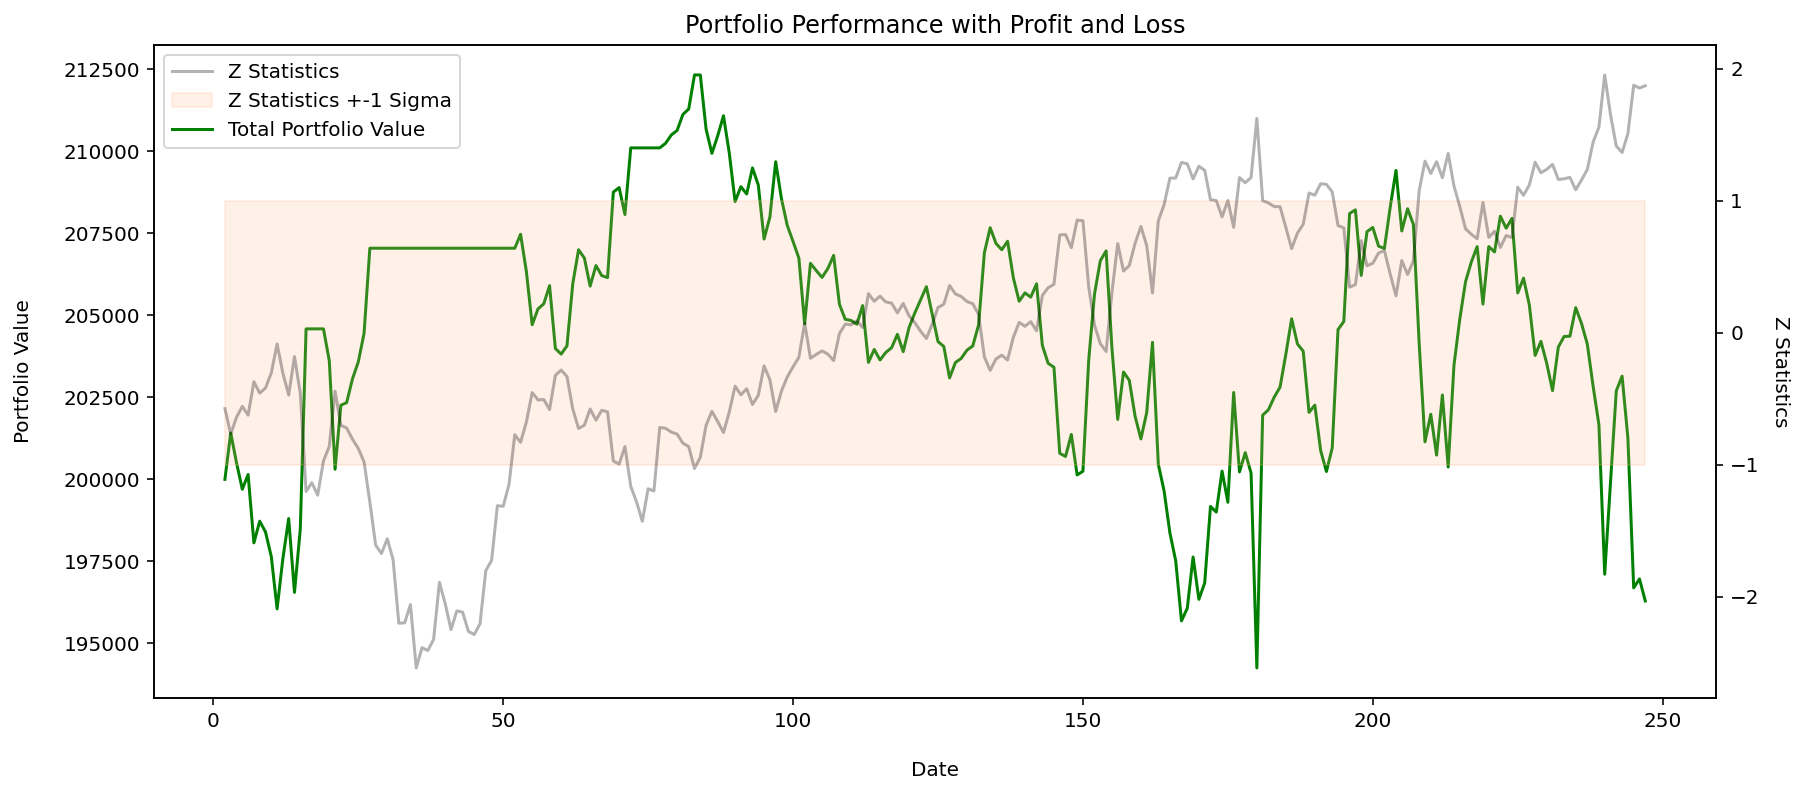

In [46]:
# plot the asset value change of the portfolio and pnl along with z-score
fig = plt.figure(figsize=(14,6),)
ax = fig.add_subplot(111)
ax2 = ax.twinx()

l1, = ax.plot(portfolio['total asset'], c='g')
l2, = ax2.plot(portfolio['z'], c='black', alpha=0.3)

b = ax2.fill_between(portfolio.index,portfolio['z upper limit'],\
                portfolio['z lower limit'], \
                alpha=0.2,color='#ffb48f')

ax.set_ylabel('Portfolio Value')
ax2.set_ylabel('Z Statistics',rotation=270)
ax.yaxis.labelpad=15
ax2.yaxis.labelpad=15
ax.set_xlabel('Date')
ax.xaxis.labelpad=15
plt.title('Portfolio Performance with Profit and Loss')
plt.legend([l2,b,l1],['Z Statistics',
                      'Z Statistics +-1 Sigma',
                      'Total Portfolio Value'],loc='upper left');
plt.savefig('chart8', dpi=400);

In [47]:
# calculate CAGR
final_portfolio = portfolio['total asset'].iloc[-1]
final_portfolio

196291.847648

In [48]:
profit = final_portfolio - 2*initial_capital
profit

-3708.1523520000046

In [49]:
roi = (profit / (2*initial_capital))*100 # Overall ROI of the pair trading strategy
roi

-1.8540761760000024

In [50]:
# delta = (portfolio.index[-1] - portfolio.index[0]).days
delta = (portfolio.index[-1] - portfolio.index[0])
print('Number of days = ', delta)

Number of days =  245


In [51]:
YEAR_DAYS = 365
returns = (final_portfolio/initial_capital) ** (YEAR_DAYS/delta) - 1
print('CAGR = {:.3f}%' .format(returns * 100))

CAGR = 173.127%
